### Code for Robust NAMLSS

In [3]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.distributions.normal
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import torchrl.modules.utils as utils

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=16, intercept=True):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, hidden_size),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(log_likelihood + robustness_factor)) / (1 + torch.exp(robustness_factor)))

        nll = -log_likelihood
        return nll

    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")

        return self

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

       

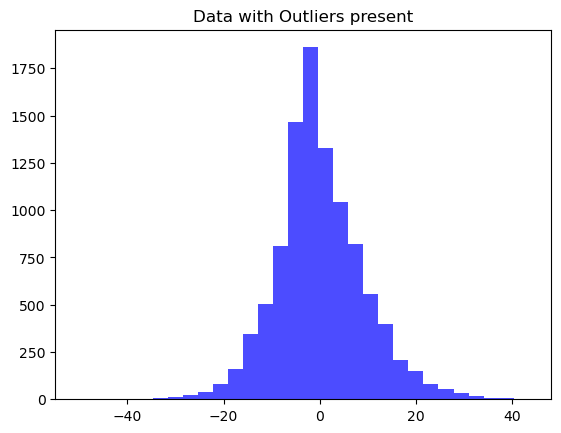

In [5]:
########## Training Dataset ##########
prop_corrupt = 0.2
n_train, n_val = 10000, 10000
BIAS = 50
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data with Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

### Sanity Check - Data without any outliers:

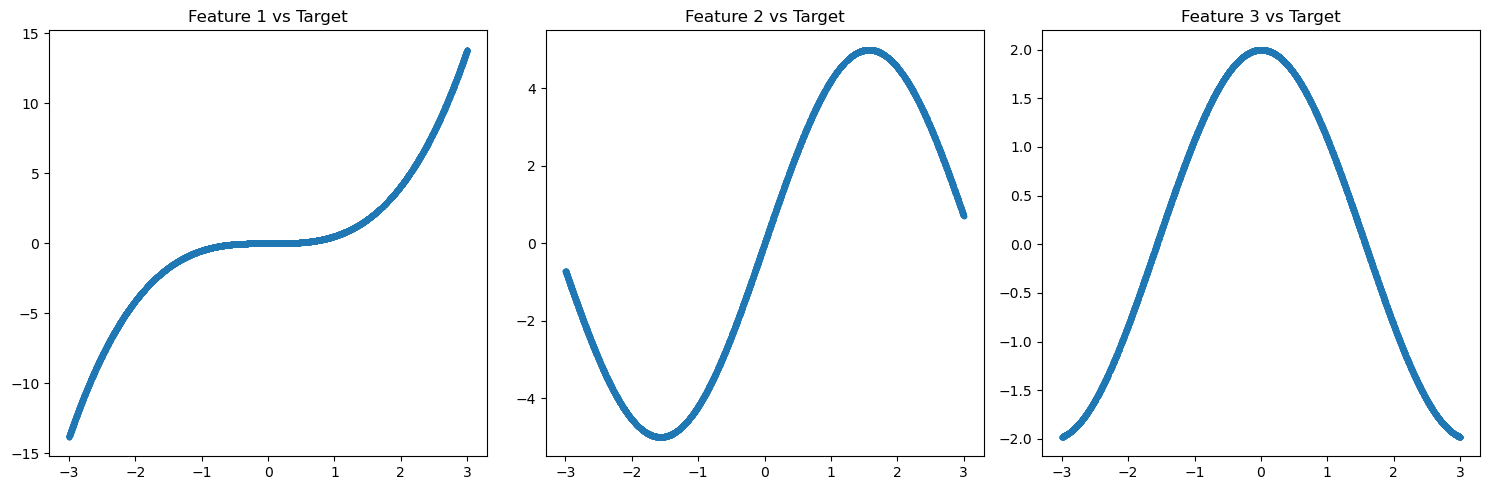

In [6]:
markersize = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot data in each subplot
axes[0].plot(X_train[:, 0], F1, "o", markersize = markersize)
axes[0].set_title("Feature 1 vs Target")

axes[1].plot(X_train[:, 1], F2, "o", markersize = markersize)
axes[1].set_title("Feature 2 vs Target")

axes[2].plot(X_train[:, 2], F3, "o", markersize = markersize)
axes[2].set_title("Feature 3 vs Target")

# Adjust layout for better appearance
plt.tight_layout()

# Show the figure
plt.show()

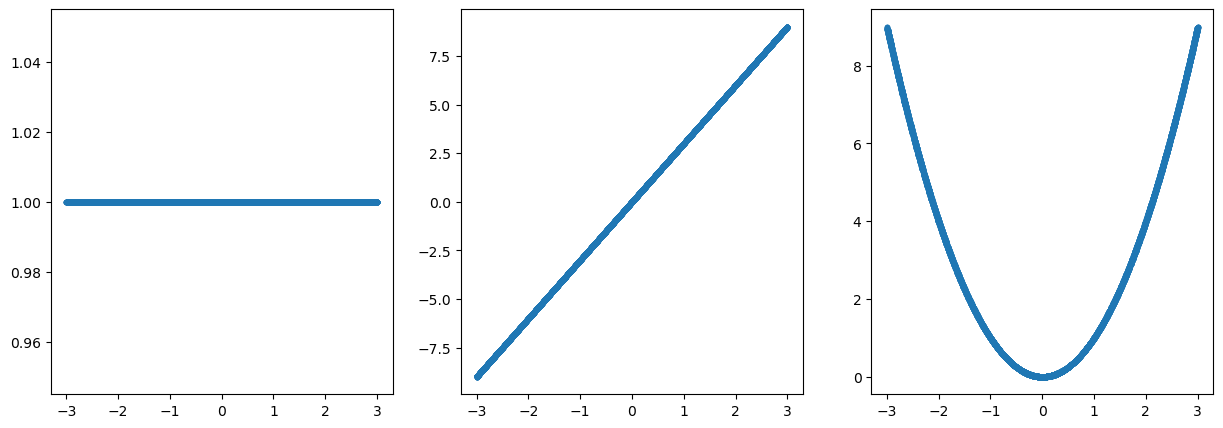

In [7]:
markersize = 3 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(X_train[:,0], S1, "o", markersize = markersize)
axes[1].plot(X_train[:,1], S2, "o", markersize = markersize)
axes[2].plot(X_train[:,2], S3, "o", markersize = markersize)
plt.show()

### Comparing a unregularized and robustified model on data without outliers:

In [5]:
nam = NormalNAMLSS(3)
nam.fit(X_train, y_train, X_val, y_val)
mu, sigma = nam.forward(X_test)

Epoch 0 - Train Loss: 7.5991 - Val Loss: 7.5037
Epoch 1 - Train Loss: 7.4982 - Val Loss: 7.4054
Epoch 2 - Train Loss: 7.3997 - Val Loss: 7.3093
Epoch 3 - Train Loss: 7.3035 - Val Loss: 7.2156
Epoch 4 - Train Loss: 7.2096 - Val Loss: 7.1240
Epoch 5 - Train Loss: 7.1179 - Val Loss: 7.0346
Epoch 6 - Train Loss: 7.0284 - Val Loss: 6.9473
Epoch 7 - Train Loss: 6.9410 - Val Loss: 6.8621
Epoch 8 - Train Loss: 6.8557 - Val Loss: 6.7790
Epoch 9 - Train Loss: 6.7724 - Val Loss: 6.6978
Epoch 10 - Train Loss: 6.6911 - Val Loss: 6.6186
Epoch 11 - Train Loss: 6.6118 - Val Loss: 6.5412
Epoch 12 - Train Loss: 6.5344 - Val Loss: 6.4658
Epoch 13 - Train Loss: 6.4589 - Val Loss: 6.3921
Epoch 14 - Train Loss: 6.3852 - Val Loss: 6.3202
Epoch 15 - Train Loss: 6.3132 - Val Loss: 6.2501
Epoch 16 - Train Loss: 6.2430 - Val Loss: 6.1816
Epoch 17 - Train Loss: 6.1745 - Val Loss: 6.1148
Epoch 18 - Train Loss: 6.1077 - Val Loss: 6.0496
Epoch 19 - Train Loss: 6.0424 - Val Loss: 5.9860
Epoch 20 - Train Loss: 5.9788 

In [6]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train, y_train, X_val, y_val, robustness_factor=torch.tensor(3))
rob_mu, rob_sigma = robust_nam.forward(X_test)

Epoch 0 - Train Loss: 3.0453 - Val Loss: 3.0449
Epoch 1 - Train Loss: 3.0448 - Val Loss: 3.0444
Epoch 2 - Train Loss: 3.0443 - Val Loss: 3.0438
Epoch 3 - Train Loss: 3.0437 - Val Loss: 3.0432
Epoch 4 - Train Loss: 3.0430 - Val Loss: 3.0425
Epoch 5 - Train Loss: 3.0423 - Val Loss: 3.0417
Epoch 6 - Train Loss: 3.0415 - Val Loss: 3.0408
Epoch 7 - Train Loss: 3.0406 - Val Loss: 3.0398
Epoch 8 - Train Loss: 3.0396 - Val Loss: 3.0387
Epoch 9 - Train Loss: 3.0385 - Val Loss: 3.0376
Epoch 10 - Train Loss: 3.0373 - Val Loss: 3.0362
Epoch 11 - Train Loss: 3.0360 - Val Loss: 3.0348
Epoch 12 - Train Loss: 3.0345 - Val Loss: 3.0332
Epoch 13 - Train Loss: 3.0329 - Val Loss: 3.0315
Epoch 14 - Train Loss: 3.0311 - Val Loss: 3.0297
Epoch 15 - Train Loss: 3.0292 - Val Loss: 3.0276
Epoch 16 - Train Loss: 3.0271 - Val Loss: 3.0254
Epoch 17 - Train Loss: 3.0249 - Val Loss: 3.0230
Epoch 18 - Train Loss: 3.0224 - Val Loss: 3.0203
Epoch 19 - Train Loss: 3.0197 - Val Loss: 3.0175
Epoch 20 - Train Loss: 3.0168 

In [7]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train, y_train, X_val, y_val, robustness_factor=torch.tensor(1))
strict_mu, strict_sigma = strict_nam.forward(X_test)

Epoch 0 - Train Loss: 1.3126 - Val Loss: 1.3126
Epoch 1 - Train Loss: 1.3126 - Val Loss: 1.3125
Epoch 2 - Train Loss: 1.3125 - Val Loss: 1.3124
Epoch 3 - Train Loss: 1.3124 - Val Loss: 1.3123
Epoch 4 - Train Loss: 1.3122 - Val Loss: 1.3122
Epoch 5 - Train Loss: 1.3121 - Val Loss: 1.3120
Epoch 6 - Train Loss: 1.3120 - Val Loss: 1.3119
Epoch 7 - Train Loss: 1.3118 - Val Loss: 1.3117
Epoch 8 - Train Loss: 1.3116 - Val Loss: 1.3115
Epoch 9 - Train Loss: 1.3115 - Val Loss: 1.3113
Epoch 10 - Train Loss: 1.3112 - Val Loss: 1.3111
Epoch 11 - Train Loss: 1.3110 - Val Loss: 1.3108
Epoch 12 - Train Loss: 1.3108 - Val Loss: 1.3106
Epoch 13 - Train Loss: 1.3105 - Val Loss: 1.3103
Epoch 14 - Train Loss: 1.3102 - Val Loss: 1.3099
Epoch 15 - Train Loss: 1.3098 - Val Loss: 1.3096
Epoch 16 - Train Loss: 1.3094 - Val Loss: 1.3092
Epoch 17 - Train Loss: 1.3090 - Val Loss: 1.3087
Epoch 18 - Train Loss: 1.3086 - Val Loss: 1.3083
Epoch 19 - Train Loss: 1.3081 - Val Loss: 1.3078
Epoch 20 - Train Loss: 1.3076 

### Clean Dataset - Mean Estimation

In [5]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test)

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\ProgramData\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'nam' is not defined

### Clean Dataset - Sigma Estimation

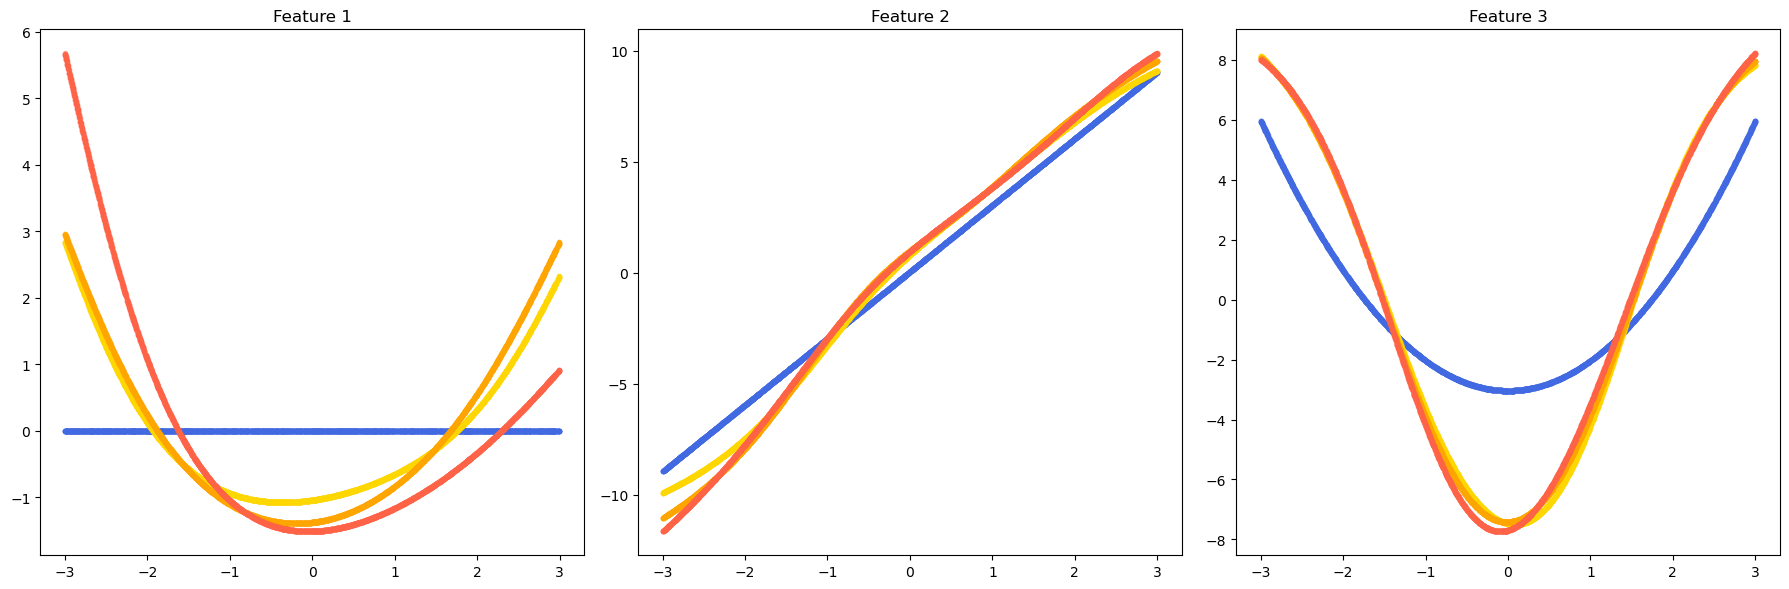

In [9]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 2
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], utils.inv_softplus(sigma_components[:, 0]) - utils.inv_softplus(sigma_components[:, 0]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], utils.inv_softplus(robust_sigma_components[:, 0]) - utils.inv_softplus(robust_sigma_components[:, 0]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], utils.inv_softplus(strict_sigma_components[:, 0]) - utils.inv_softplus(strict_sigma_components[:, 0]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], utils.inv_softplus(sigma_components[:, 1]) - utils.inv_softplus(sigma_components[:, 1]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], utils.inv_softplus(robust_sigma_components[:, 1]) - utils.inv_softplus(robust_sigma_components[:, 1]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], utils.inv_softplus(strict_sigma_components[:, 1]) - utils.inv_softplus(strict_sigma_components[:, 1]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 2
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], utils.inv_softplus(sigma_components[:, 2]) - utils.inv_softplus(sigma_components[:, 2]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], utils.inv_softplus(robust_sigma_components[:, 2]) - utils.inv_softplus(robust_sigma_components[:, 2]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], utils.inv_softplus(strict_sigma_components[:, 2]) - utils.inv_softplus(strict_sigma_components[:, 2]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Data Example

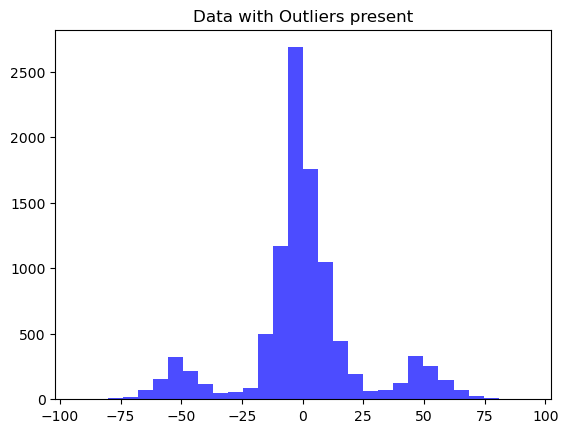

In [10]:
########## Training Dataset ##########
prop_corrupt = 0.2
n_train, n_val = 10000, 10000
BIAS = 50
Uniform = dist.Uniform(-3, 3)
X_train = Uniform.sample(sample_shape = [n_train, 3])

F1 = (0.8 * X_train[:,0])**3
F2 = 5 * np.sin(X_train[:,1])
F3 = 2 * np.cos(X_train[:,2])

S1 = torch.ones(n_train)
S2 = X_train[:,1] * 3
S3 = X_train[:,2]**2

y_train = F1 + F2 + F3 + torch.normal(torch.zeros(n_train), std = F.softplus(S1 + S2 + S3))
y_train = y_train.view(n_train, 1)

corrupted_indices = random.sample(range(1, n_train), int(n_train * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_train[corrupted_indices] = y_train[corrupted_indices] + BIAS * sign

plt.hist(y_train.detach().numpy(), bins = 30, color = "blue", alpha = 0.7)
plt.title("Data with Outliers present")
plt.show()

########## Validation Dataset ###########

X_val = Uniform.sample(sample_shape = [n_val, 3])

F1_val = (0.8 * X_val[:,0])**3
F2_val = 5 * np.sin(X_val[:,1])
F3_val = 2 * np.cos(X_val[:,2])

S1_val = torch.ones(n_val)
S2_val = X_val[:,1] * 3
S3_val = X_val[:,2]**2

y_val = F1_val + F2_val + F3_val + torch.normal(torch.zeros(n_val), std = F.softplus(S1_val + S2_val + S3_val))
y_val = y_val.view(n_val, 1)

corrupted_indices = random.sample(range(1, n_val), int(n_val * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_val[corrupted_indices] = y_val[corrupted_indices] + BIAS * sign

########## Testing Dataset ##########
n_test = 5000
X_test = Uniform.sample(sample_shape = [n_test, 3])

F1_test = (0.8 * X_test[:,0])**3
F2_test = 5 * np.sin(X_test[:,1])
F3_test = 2 * np.cos(X_test[:,2])

S1_test = torch.ones(n_test)
S2_test = X_test[:, 1] * 3
S3_test = X_test[:, 2] ** 2

y_test = F1_test + F2_test + F3_test + torch.normal(torch.zeros(n_test), std = F.softplus(S1_test + S2_test + S3_test))
y_test = y_test.view(n_test, 1)

corrupted_indices = random.sample(range(1, n_test), int(n_test * prop_corrupt))
sign = (2 * torch.randint(0, 2, (len(corrupted_indices),)) - 1).unsqueeze(1)
y_test[corrupted_indices] = y_test[corrupted_indices] + BIAS * sign

In [11]:
nam = NormalNAMLSS(3)
nam.fit(X_train, y_train, X_val, y_val)
mu, sigma = nam.forward(X_test)

Epoch 0 - Train Loss: 45.0219 - Val Loss: 44.9513
Epoch 1 - Train Loss: 44.2368 - Val Loss: 44.1601
Epoch 2 - Train Loss: 43.4684 - Val Loss: 43.3860
Epoch 3 - Train Loss: 42.7165 - Val Loss: 42.6286
Epoch 4 - Train Loss: 41.9806 - Val Loss: 41.8872
Epoch 5 - Train Loss: 41.2601 - Val Loss: 41.1610
Epoch 6 - Train Loss: 40.5542 - Val Loss: 40.4493
Epoch 7 - Train Loss: 39.8623 - Val Loss: 39.7518
Epoch 8 - Train Loss: 39.1839 - Val Loss: 39.0679
Epoch 9 - Train Loss: 38.5186 - Val Loss: 38.3972
Epoch 10 - Train Loss: 37.8661 - Val Loss: 37.7394
Epoch 11 - Train Loss: 37.2259 - Val Loss: 37.0941
Epoch 12 - Train Loss: 36.5977 - Val Loss: 36.4609
Epoch 13 - Train Loss: 35.9812 - Val Loss: 35.8395
Epoch 14 - Train Loss: 35.3761 - Val Loss: 35.2295
Epoch 15 - Train Loss: 34.7820 - Val Loss: 34.6307
Epoch 16 - Train Loss: 34.1987 - Val Loss: 34.0428
Epoch 17 - Train Loss: 33.6259 - Val Loss: 33.4655
Epoch 18 - Train Loss: 33.0633 - Val Loss: 32.8985
Epoch 19 - Train Loss: 32.5106 - Val Loss

In [19]:
robust_nam = NormalNAMLSS(3)
robust_nam.fit(X_train, y_train, robustness_factor = torch.tensor(1))
robust_mu, robust_sigma = robust_nam.forward(X_test)

Epoch 0 - Train Loss: 1.3133
Epoch 100 - Train Loss: 1.3133
Epoch 200 - Train Loss: 1.3133
Epoch 300 - Train Loss: 1.3133
Epoch 400 - Train Loss: 1.3133
Epoch 500 - Train Loss: 1.3133
Epoch 600 - Train Loss: 1.3133
Epoch 700 - Train Loss: 1.3133
Epoch 800 - Train Loss: 1.3133
Epoch 900 - Train Loss: 1.3133
Epoch 1000 - Train Loss: 1.3133
Epoch 1100 - Train Loss: 1.3133
Epoch 1200 - Train Loss: 1.3133
Epoch 1300 - Train Loss: 1.3133
Epoch 1400 - Train Loss: 1.3133
Epoch 1500 - Train Loss: 1.3133
Epoch 1600 - Train Loss: 1.3133
Epoch 1700 - Train Loss: 1.3133
Epoch 1800 - Train Loss: 1.3133
Epoch 1900 - Train Loss: 1.3133
Epoch 2000 - Train Loss: 1.3133
Epoch 2100 - Train Loss: 1.3133
Epoch 2200 - Train Loss: 1.3133
Epoch 2300 - Train Loss: 1.3133
Epoch 2400 - Train Loss: 1.3133
Epoch 2500 - Train Loss: 1.3133
Epoch 2600 - Train Loss: 1.3133
Epoch 2700 - Train Loss: 1.3133
Epoch 2800 - Train Loss: 1.3133
Epoch 2900 - Train Loss: 1.3133
Epoch 3000 - Train Loss: 1.3133
Epoch 3100 - Train L

In [20]:
strict_nam = NormalNAMLSS(3)
strict_nam.fit(X_train, y_train, robustness_factor=torch.tensor(0))
strict_mu, strict_sigma = strict_nam.forward(X_test)

Epoch 0 - Train Loss: 0.6931
Epoch 100 - Train Loss: 0.6931
Epoch 200 - Train Loss: 0.6931
Epoch 300 - Train Loss: 0.6931
Epoch 400 - Train Loss: 0.6931
Epoch 500 - Train Loss: 0.6931
Epoch 600 - Train Loss: 0.6931
Epoch 700 - Train Loss: 0.6931
Epoch 800 - Train Loss: 0.6931
Epoch 900 - Train Loss: 0.6931
Epoch 1000 - Train Loss: 0.6931
Epoch 1100 - Train Loss: 0.6931
Epoch 1200 - Train Loss: 0.6931
Epoch 1300 - Train Loss: 0.6931
Epoch 1400 - Train Loss: 0.6931
Epoch 1500 - Train Loss: 0.6931
Epoch 1600 - Train Loss: 0.6931
Epoch 1700 - Train Loss: 0.6931
Epoch 1800 - Train Loss: 0.6931
Epoch 1900 - Train Loss: 0.6931
Epoch 2000 - Train Loss: 0.6931
Epoch 2100 - Train Loss: 0.6931
Epoch 2200 - Train Loss: 0.6931
Epoch 2300 - Train Loss: 0.6931
Epoch 2400 - Train Loss: 0.6931
Epoch 2500 - Train Loss: 0.6931
Epoch 2600 - Train Loss: 0.6931
Epoch 2700 - Train Loss: 0.6931
Epoch 2800 - Train Loss: 0.6931
Epoch 2900 - Train Loss: 0.6931
Epoch 3000 - Train Loss: 0.6931
Epoch 3100 - Train L

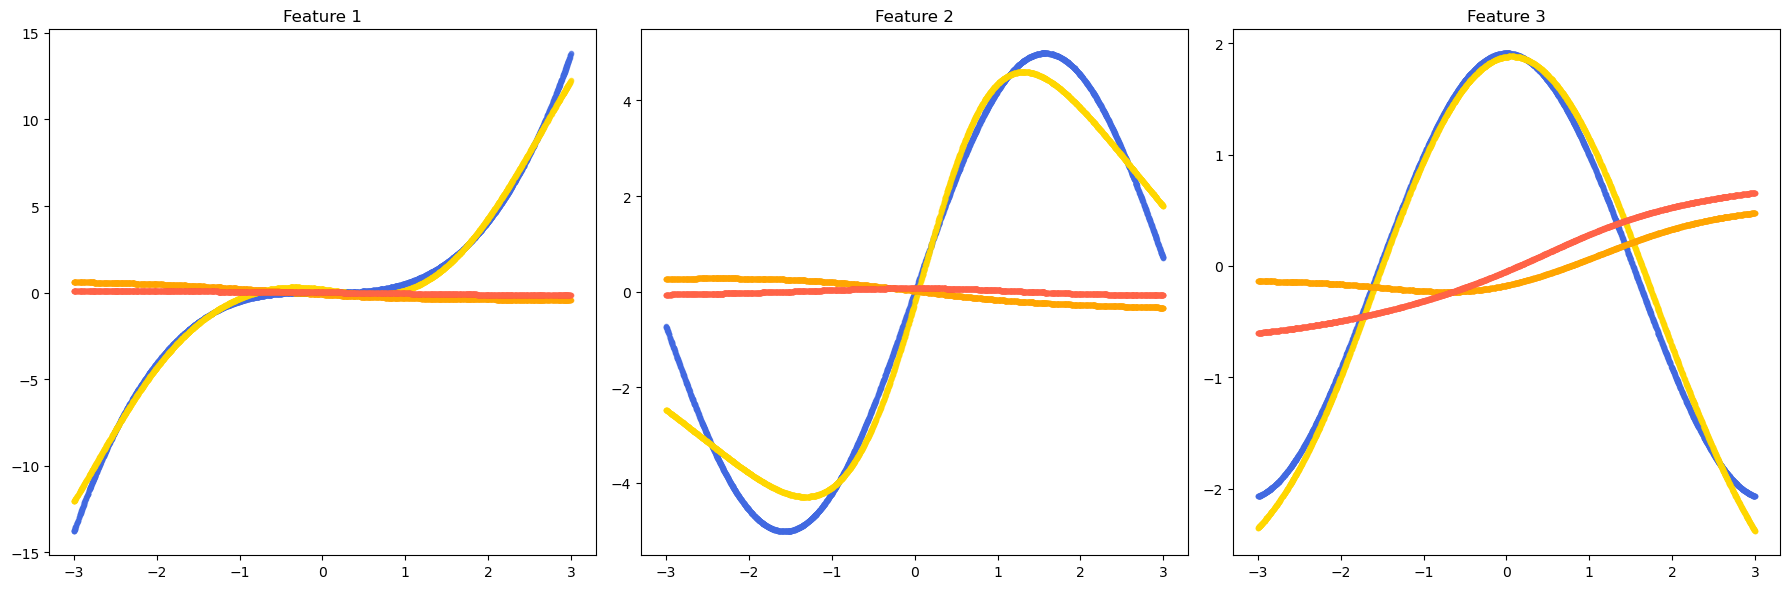

In [21]:
# Configuration
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

########## Marginal Effect Plots ##########
mu_components, sigma_components = nam.marginal_effects(X_test)
robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test)
strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test)

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 1
axes[0].plot(X_test[:, 0], F1_test - F1_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[0].plot(X_test[:, 0], mu_components[:, 0] - mu_components[:, 0].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[0].plot(X_test[:, 0], robust_mu_components[:, 0] - robust_mu_components[:, 0].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], strict_mu_components[:, 0] - strict_mu_components[:, 0].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], F2_test - F2_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[1].plot(X_test[:, 1], mu_components[:, 1] - mu_components[:, 1].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[1].plot(X_test[:, 1], robust_mu_components[:, 1] - robust_mu_components[:, 1].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], strict_mu_components[:, 1] - strict_mu_components[:, 1].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 3
axes[2].plot(X_test[:, 2], F3_test - F3_test.mean(), "o", markersize=markersize, color=true_color, alpha=alpha)
axes[2].plot(X_test[:, 2], mu_components[:, 2] - mu_components[:, 2].mean(), "o", markersize=markersize, color=unregulated_color, alpha=alpha)
axes[2].plot(X_test[:, 2], robust_mu_components[:, 2] - robust_mu_components[:, 2].mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], strict_mu_components[:, 2] - strict_mu_components[:, 2].mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

### Corrupted Dataset - Sigma Estimation

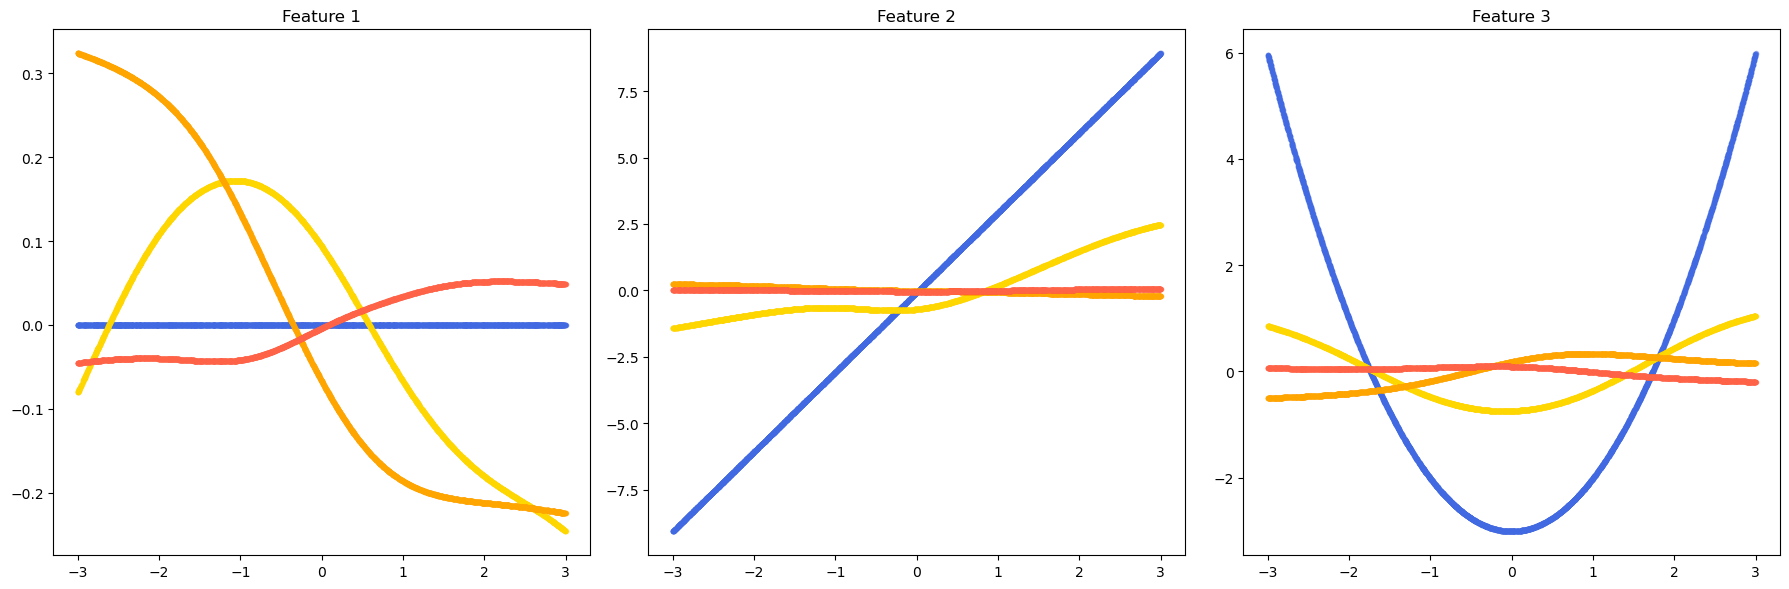

In [25]:
markersize = 3
alpha = 0.4

true_color = "royalblue"
unregulated_color = "gold"
robust_color = "orange"
strict_color = "tomato"

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot for Feature 2
axes[0].plot(X_test[:, 0], S1_test - S1_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[0].plot(X_test[:, 0], utils.inv_softplus(sigma_components[:, 0]) - utils.inv_softplus(sigma_components[:, 0]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[0].plot(X_test[:, 0], utils.inv_softplus(robust_sigma_components[:, 0]) - utils.inv_softplus(robust_sigma_components[:, 0]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[0].plot(X_test[:, 0], utils.inv_softplus(strict_sigma_components[:, 0]) - utils.inv_softplus(strict_sigma_components[:, 0]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[0].set_title("Feature 1")

# Plot for Feature 2
axes[1].plot(X_test[:, 1], S2_test - S2_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[1].plot(X_test[:, 1], utils.inv_softplus(sigma_components[:, 1]) - utils.inv_softplus(sigma_components[:, 1]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[1].plot(X_test[:, 1], utils.inv_softplus(robust_sigma_components[:, 1]) - utils.inv_softplus(robust_sigma_components[:, 1]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[1].plot(X_test[:, 1], utils.inv_softplus(strict_sigma_components[:, 1]) - utils.inv_softplus(strict_sigma_components[:, 1]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[1].set_title("Feature 2")

# Plot for Feature 2
axes[2].plot(X_test[:, 2], S3_test - S3_test.mean(), "o", markersize = markersize, alpha = alpha, color = true_color)
axes[2].plot(X_test[:, 2], utils.inv_softplus(sigma_components[:, 2]) - utils.inv_softplus(sigma_components[:, 2]).mean(), "o", markersize=markersize, alpha=alpha, color=unregulated_color)
axes[2].plot(X_test[:, 2], utils.inv_softplus(robust_sigma_components[:, 2]) - utils.inv_softplus(robust_sigma_components[:, 2]).mean(), "o", markersize=markersize, color=robust_color, alpha=alpha)
axes[2].plot(X_test[:, 2], utils.inv_softplus(strict_sigma_components[:, 2]) - utils.inv_softplus(strict_sigma_components[:, 2]).mean(), "o", markersize=markersize, color=strict_color, alpha=alpha)
axes[2].set_title("Feature 3")

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()

TODO:
- Herumspielen mit Validation Data
- Inverses der Softplus Funktion vor Standardisierung verwenden
- Im Notfall symmetrische Corruption

### Ideen:
-